Check the GPU, make sure it is Tesla P100-PCIE or V100-SXM2

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Fri Apr 22 08:05:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Connect Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/markus-k/bisenetv2-tf2.git
!mv bisenetv2-tf2/* ./

Cloning into 'bisenetv2-tf2'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 104 (delta 53), reused 73 (delta 24), pack-reused 0
Receiving objects: 100% (104/104), 4.18 MiB | 25.93 MiB/s, done.
Resolving deltas: 100% (53/53), done.


##Import libraries
#### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [ ]:
# %tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())

import datetime
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers

import tensorflow_datasets as tfds

from tensorflow.data import AUTOTUNE

from utils import display_dataset, predict_tf

import cv2
from PIL import Image
from skimage import io
import random as rng

# classification
from tensorflow.keras.models import Model
import scipy as sp
from google.colab.patches import cv2_imshow

2.8.0
/device:GPU:0


# Segmentation model

In [ ]:
from model import bisenetv2_compiled, bisenetv2_output_shape

INPUT_SHAPE = (256, 512, 3)
NUM_CLASSES = 2
SCALE = 8
OUTPUT_SHAPE = bisenetv2_output_shape(NUM_CLASSES, SCALE, input_shape=INPUT_SHAPE)
# create model
model = bisenetv2_compiled(num_classes=NUM_CLASSES, out_scale=SCALE, input_shape=INPUT_SHAPE)
# model = tf.keras.models.load_model('drive/MyDrive/colab_data/chimei_2_views/checkpoints/UNet/UNET_efficientnetb1_no_weight_model.h5')
# load weights
model.load_weights('drive/MyDrive/colab_data/chimei_2_views/checkpoints/BiSeNetV2/20220415_568_80/BiSeNetV2_568_1to80_11_0.92_weight.h5') 

tensorflow_addons not available, not using weight-decay


In [ ]:
model.summary()

# AP view classification model

In [ ]:
model_AP = tf.keras.models.load_model('drive/MyDrive/colab_data/chimei_2_views/checkpoints/Classification/20211213_366_custom_AP/custom_366_4_classes_96_0.99.h5')
gap_weights_AP = model_AP.layers[-1].get_weights()[0]
cam_model_AP  = Model(inputs=model_AP.input, outputs=(model_AP.layers[-3].output, model_AP.layers[-1].output))
cam_model_AP.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1849

# Lateral view classification model

In [ ]:
model_Lateral = tf.keras.models.load_model('drive/MyDrive/colab_data/chimei_2_views/checkpoints/Classification/20211209_147_custom_lateral/custom_147_3_classes_53_0.95.h5')
gap_weights_Lateral = model_Lateral.layers[-1].get_weights()[0]
cam_model_Lateral  = Model(inputs=model_Lateral.input, outputs=(model_Lateral.layers[-3].output, model_Lateral.layers[-1].output))
cam_model_Lateral.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1849

# Utils

In [ ]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def draw_color(input_image, mask_image):
    colors = [(0,0,0),      #bg
              (250,0,0)]    #heart
    classes = ['bg', 'heart']
    out_image = np.zeros_like(input_image)
    #print("mask image shape is:", mask_image.shape)
    for i in range(len(classes)):
        class_mask = mask_image[...,i] # get the layer of class
        class_mask = np.stack((class_mask * colors[i][0], class_mask * colors[i][1], class_mask * colors[i][2]), axis=-1)
        out_image = out_image + class_mask
    
    out_image= out_image.astype(int) # make it int so plt.imshow can show rgb 0-255, float will show 0-1
    return out_image

def save_color(pr_mask, pr_mask_path):
    colors = [(0,0,0),      #bg
              (250,0,0)]    #heart     

    height, width = pr_mask.shape[0], pr_mask.shape[1]
    img_mask = Image.new(mode = "RGB", size = (width, height))
    px = img_mask.load()

    for x in range(0,width):
        for y in range(0,height):
             px[x,y] = colors[pr_mask[y][x]]
      
    img_mask.save(pr_mask_path)


def visualize_test(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(6, 3)) #16,5
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        # plt.xticks([])
        # plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


def draw_combined_color(mask_image):
    colors = {0:0,      #bg 0
              1:250,    #diastole 1
              -1:100}    #systole -1

    out_image = np.zeros_like(mask_image)

    for k,v in colors.items():
        class_mask = (mask_image==k) # get the layer of class
        class_mask = class_mask * colors[k]
        out_image = out_image + class_mask
    
    out_image= out_image.astype(int) # make it int so plt.imshow can show rgb 0-255, float will show 0-1
    return out_image


def get_enclosing_circle(pr_mask, threshold=100):
    """
    input:
        pr_mask is numpy array with shape (width height)
        threshold max 255 default 100
    outputs:
        enclosing circle center and radius
    """
    colors = [0,      #bg
              250]    #heart    

    height, width = pr_mask.shape[0], pr_mask.shape[1]
    img_mask = Image.new(mode = "L", size = (width, height))
    px = img_mask.load()

    for x in range(0,width):
        for y in range(0,height):
             px[x,y] = colors[pr_mask[y][x]]
        
    img_mask.save("enclosing.jpg")
    # cv2 process from here
    src = cv2.imread("enclosing.jpg")
    src_blur = cv2.blur(src, (3,3))
    # cv2.imwrite("enclosing_blur.jpg", src_blur)
    # Detect edges using Canny
    canny_output = cv2.Canny(src_blur, threshold, threshold * 2)
    # cv2.imwrite("enclosing_canny.jpg", canny_output)
    # Find contours
    contours, _ = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Approximate contours to polygons + get bounding rects and circles
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        centers[i], radius[i] = cv2.minEnclosingCircle(contours_poly[i])
    # draw result
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    # Draw polygonal contour + bonding rects + circles
    temp_i = 0
    temp_r = 0
    for i in range(len(contours)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv2.drawContours(drawing, contours_poly, i, color)
        cv2.circle(drawing, (int(centers[i][0]), int(centers[i][1])), int(radius[i]), color, 2)
        # keep the biggest circle for output
        if int(radius[i]) > temp_r:
          temp_r = int(radius[i])
          temp_i = i
    # cv2.imwrite('enclosing_contours.jpg', drawing)
    return int(centers[temp_i][0]), int(centers[temp_i][1]), int(radius[temp_i])


def combine_2_images(width=256*2, height=256, testdata_folder="CamVid/test/"):
  # combine 2 view images and resize it to target size
  temp_image_list = [f for f in os.listdir("tmp_front") if not f.startswith('.')]
  temp_image_L_list = [f for f in os.listdir("tmp_lateral") if not f.startswith('.')]
  assert len(temp_image_list) == len(temp_image_L_list)
  print("combining", len(temp_image_list), "images")
  for i in range(len(temp_image_list)):
    # generate image
    img = cv2.imread(os.path.join("tmp_front", temp_image_list[i]))
    img_L = cv2.imread(os.path.join("tmp_lateral", temp_image_L_list[i]))
    vis = np.concatenate((img, img_L), axis=1)
    vis = cv2.resize(vis, (width,height), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(os.path.join(testdata_folder, temp_image_list[i].split('.')[0]+temp_image_L_list[i].split('.')[0].split('_')[-1]+'.png'), vis)


def find_max_min(testdata_folder="CamVid/test/", savedata_folder = "chimei_predicted/", 
                 width=256, height=256, skip_start=25, skip_end=25, min_threshold=20):
  """
  skip_start, skip_end can make sure developer well spread
  min_threshold can make sure developer not gone
  """
  testdatalist = os.listdir(testdata_folder)
  # sort the file name
  testdatalist.sort()
  total_images = len(testdatalist)
  print("total test images:", len(testdatalist))
  savedatalist = os.listdir(savedata_folder)
  print("total predicted images:", len(savedatalist))

  # original images dict
  test_dict = dict(enumerate(testdatalist))
  # count the pixel of heart
  heart_max = 0
  heart_min = width*height
  max_file = str()
  min_file = str()
  max_key = int()
  min_key = int()

  # get the max area image first
  for k,i in enumerate(testdatalist):
      if k > skip_start and k < total_images-skip_end:
        image = io.imread(os.path.join(testdata_folder, i)) # novel image
        image = image / 255
        # convert 1 channel to 3 channel if necessary
        if len(image.shape) == 2:
          image = np.stack((image,)*3, axis=-1)
        image = np.expand_dims(image, axis = 0) # change the shape to (1, H, W)
        pr_mask = model.predict(image) 
        pr_mask = pr_mask.squeeze()
        pr_mask = np.argmax(pr_mask, axis = 2)
        save_color(pr_mask, savedata_folder + i)
        # print("complete ", savedata_folder + i)
        # crop front view image on the left side
        pr_mask = pr_mask[:,:256]
        # count the pixels of heart(label==1)
        heart = np.sum(pr_mask==1)
        if heart > heart_max:
          heart_max = heart
          max_file = i
          max_key = k

  # get the min area image, the min image should appear after max image
  for k,i in enumerate(testdatalist):
      if k > max_key and k < max_key+min_threshold:
        image = io.imread(os.path.join(testdata_folder, i)) # novel image
        image = image / 255
        # convert 1 channel to 3 channel if necessary
        if len(image.shape) == 2:
          image = np.stack((image,)*3, axis=-1)
        image = np.expand_dims(image, axis = 0) # change the shape to (1 H, W)
        pr_mask = model.predict(image) 
        pr_mask = pr_mask.squeeze()
        pr_mask = np.argmax(pr_mask, axis = 2)
        # print("complete ", savedata_folder + i)
        # crop front view image on the left side
        pr_mask = pr_mask[:,:256]
        # count the pixels of heart(label==1)
        heart = np.sum(pr_mask==1)
        if heart < heart_min:
          heart_min = heart
          min_file = i
          min_key = k

  # check the results
  print("max_key is:", max_key, max_file)
  print("min_key is:", min_key, min_file)
  return heart_max, max_file, max_key, heart_min, min_file, min_key, total_images, test_dict


def calculate_EF(max_file, min_file, heart_max, heart_min, total_images, test_dict, testdata_folder="CamVid/test/", savedata_folder = "chimei_predicted/", average_count=3):
  # check how many masks were predicted 
  savedatalist = os.listdir(savedata_folder)
  print("total predicted images:", len(savedatalist))

  # set parameters
  max_area_list = []
  min_area_list = []
  max_L_list = []
  min_L_list = []

  # draw the max image
  print("max filename:", max_file)
  image = io.imread(os.path.join(testdata_folder, max_file)) 
  image = image / 255
  # convert 1 channel to 3 channel if necessary
  if len(image.shape) == 2:
    image = np.stack((image,)*3, axis=-1)
  image = np.expand_dims(image, axis = 0)
  pr_mask = model.predict(image)
  ### save mask for later combined image use
  # crop front view image on the left side
  pr_mask_max = pr_mask
  pr_mask_max = pr_mask_max.squeeze()
  pr_mask_max = np.argmax(pr_mask_max, axis = 2)
  pr_mask_max = pr_mask_max[:,:256] 
  # print("max shape:", pr_mask_max.shape)
  ###
  pr_mask = draw_color(image, pr_mask)
  visualize_test(
          image=denormalize(image.squeeze()),
          pr_mask=pr_mask.squeeze(),
  )

  # draw the min image
  print("min filename:", min_file)
  image = io.imread(os.path.join(testdata_folder, min_file)) 
  image = image / 255
  # convert 1 channel to 3 channel if necessary
  if len(image.shape) == 2:
    image = np.stack((image,)*3, axis=-1)
  image = np.expand_dims(image, axis = 0)
  pr_mask = model.predict(image)
  ### save mask for later combined image use
  # crop front view image on the left side
  pr_mask_min = pr_mask
  pr_mask_min = pr_mask_min.squeeze()
  pr_mask_min = np.argmax(pr_mask_min, axis = 2)
  pr_mask_min = pr_mask_min[:,:256] 
  ###
  pr_mask = draw_color(image, pr_mask)
  visualize_test(
          image=denormalize(image.squeeze()),
          pr_mask=pr_mask.squeeze(),
  )

  # get the max list
  for i in range(average_count):
    if max_key+i-(average_count-1)/2 >= 0 and max_key+i-(average_count-1)/2 < total_images:
      key = int(max_key+i-(average_count-1)/2)
      image = io.imread(os.path.join(testdata_folder, test_dict[key]))
      image = image / 255
      # convert 1 channel to 3 channel if necessary
      if len(image.shape) == 2:
        image = np.stack((image,)*3, axis=-1)
      # print(test_dict[max_key+i-(average_count-1)/2])
      image = np.expand_dims(image, axis = 0)
      pr_mask = model.predict(image)
      pr_mask = pr_mask.squeeze()
      pr_mask = np.argmax(pr_mask, axis = 2)
      pr_mask = pr_mask[:,:256] 
      # make sure the value is not too different from the original one
      if abs(heart_max - np.sum(pr_mask==1)) < heart_max*0.2:
        max_area_list.append(np.sum(pr_mask==1))
        _, _, r_max = get_enclosing_circle(pr_mask)
        max_L_list.append(2*r_max)

  # get the min list
  for i in range(average_count):
    if min_key+i-(average_count-1)/2 >= 0 and min_key+i-(average_count-1)/2 < total_images:
      key = int(min_key+i-(average_count-1)/2)
      image = io.imread(os.path.join(testdata_folder, test_dict[key])) 
      image = image / 255
      # convert 1 channel to 3 channel if necessary
      if len(image.shape) == 2:
        image = np.stack((image,)*3, axis=-1)
      # print(test_dict[min_key+i-(average_count-1)/2])
      image = np.expand_dims(image, axis = 0)
      pr_mask = model.predict(image)
      pr_mask = pr_mask.squeeze()
      pr_mask = np.argmax(pr_mask, axis = 2)
      pr_mask = pr_mask[:,:256] 
      # make sure the value is not too different from the original one
      if abs(heart_min - np.sum(pr_mask==1)) < heart_min*0.2:
        min_area_list.append(np.sum(pr_mask==1))
        _, _, r_min = get_enclosing_circle(pr_mask)
        min_L_list.append(2*r_min)

  # print results
  heart_max = sum(max_area_list) / len(max_area_list)
  heart_min = sum(min_area_list) / len(min_area_list)
  L_max = sum(max_L_list) / len(max_L_list)
  L_min = sum(min_L_list) / len(min_L_list)
  EF = round((heart_max**2/L_max - heart_min**2/L_min)/(heart_max**2/L_max),2)*100
  print("EF((EDV-ESV)/EDV):", EF)
  print("the max area is:", max_area_list)
  print("the min area is:", min_area_list)
  print("the L of max area is:", max_L_list)
  print("the L of min area is:", min_L_list)
  
  return pr_mask_max , pr_mask_min, EF


def make_donut(pr_mask_min, pr_mask_max, test_target):
  # min image process
  pr_mask_min_t = np.where(pr_mask_min == 2, 0, pr_mask_min) # make unlabelled as background
  pr_mask_min_t = pr_mask_min_t * -1 # make the systole label as -1 for later calculation
  unique, counts = np.unique(pr_mask_min_t, return_counts=True)
  print(dict(zip(unique, counts)))

  # max image process
  pr_mask_max_t = np.where(pr_mask_max == 2, 0, pr_mask_max) # make unlabelled as background
  unique, counts = np.unique(pr_mask_max_t, return_counts=True)
  print(dict(zip(unique, counts)))

  # combine two images
  pr_mask_combined = pr_mask_min_t + pr_mask_max_t
  unique, counts = np.unique(pr_mask_combined, return_counts=True)
  print(dict(zip(unique, counts)))

  # draw the image
  pr_mask_combined_draw = draw_combined_color(pr_mask_combined)
  io.imsave(test_target + "_combined.png", pr_mask_combined_draw)
  plt.title('combined image')
  plt.imshow(pr_mask_combined_draw)


def make_lateral_donut(max_file, min_file, test_target, testdata_folder="CamVid/test/"):
  # get the max image
  print("max filename:", max_file)
  image = io.imread(os.path.join(testdata_folder, max_file)) 
  image = image / 255
  # convert 1 channel to 3 channel if necessary
  if len(image.shape) == 2:
    image = np.stack((image,)*3, axis=-1)
  image = np.expand_dims(image, axis = 0)
  pr_mask = model.predict(image)
  ### save mask for later combined image use
  # crop lateral view image on the right side
  pr_mask_max = pr_mask
  pr_mask_max = pr_mask_max.squeeze()
  pr_mask_max = np.argmax(pr_mask_max, axis = 2)
  pr_mask_max = pr_mask_max[:,256:] 

  # get the min image
  print("min filename:", min_file)
  image = io.imread(os.path.join(testdata_folder, min_file)) 
  image = image / 255
  # convert 1 channel to 3 channel if necessary
  if len(image.shape) == 2:
    image = np.stack((image,)*3, axis=-1)
  image = np.expand_dims(image, axis = 0)
  pr_mask = model.predict(image)
  ### save mask for later combined image use
  # crop lateral view image on the right side
  pr_mask_min = pr_mask
  pr_mask_min = pr_mask_min.squeeze()
  pr_mask_min = np.argmax(pr_mask_min, axis = 2)
  pr_mask_min = pr_mask_min[:,256:] 

  # min image process
  pr_mask_min_t = np.where(pr_mask_min == 2, 0, pr_mask_min) # make unlabelled as background
  pr_mask_min_t = pr_mask_min_t * -1 # make the systole label as -1 for later calculation
  unique, counts = np.unique(pr_mask_min_t, return_counts=True)
  # print(dict(zip(unique, counts)))

  # max image process
  pr_mask_max_t = np.where(pr_mask_max == 2, 0, pr_mask_max) # make unlabelled as background
  unique, counts = np.unique(pr_mask_max_t, return_counts=True)
  # print(dict(zip(unique, counts)))

  # combine two images
  pr_mask_combined = pr_mask_min_t + pr_mask_max_t
  unique, counts = np.unique(pr_mask_combined, return_counts=True)
  # print(dict(zip(unique, counts)))

  # draw the image
  pr_mask_combined_draw = draw_combined_color(pr_mask_combined)
  io.imsave(test_target + "_combined_l.png", pr_mask_combined_draw)
  plt.title('combined image')
  plt.imshow(pr_mask_combined_draw)


def find_max_min_lateral(test_dict, total_images, testdata_folder="CamVid/test/",
                         width=256, height=256, skip_start=25, skip_end=25, min_threshold=20):
  """
  skip_start, skip_end can make sure developer well spread
  min_threshold can make sure developer not gone
  """
  # count the pixel of heart
  heart_max = 0
  heart_min = width*height
  max_file = str()
  min_file = str()
  max_key = int()
  min_key = int()

  # get the max area image first
  for k,i in test_dict.items():
      if k > skip_start and k < total_images-skip_end:
        image = io.imread(os.path.join(testdata_folder, i)) # novel image
        image = image / 255
        # convert 1 channel to 3 channel if necessary
        if len(image.shape) == 2:
          image = np.stack((image,)*3, axis=-1)
        image = np.expand_dims(image, axis = 0) # change the shape to (1, H, W)
        pr_mask = model.predict(image) 
        pr_mask = pr_mask.squeeze()
        pr_mask = np.argmax(pr_mask, axis = 2)
        # crop lateral view image on the right side
        pr_mask = pr_mask[:,256:]
        # count the pixels of heart(label==1)
        heart = np.sum(pr_mask==1)
        if heart > heart_max:
          heart_max = heart
          max_file = i
          max_key = k

  # get the min area image, the min image should appear after max image
  for k,i in test_dict.items():
      if k > max_key and k < max_key+min_threshold:
        image = io.imread(os.path.join(testdata_folder, i)) # novel image
        image = image / 255
        # convert 1 channel to 3 channel if necessary
        if len(image.shape) == 2:
          image = np.stack((image,)*3, axis=-1)
        image = np.expand_dims(image, axis = 0) # change the shape to (1 H, W)
        pr_mask = model.predict(image) 
        pr_mask = pr_mask.squeeze()
        pr_mask = np.argmax(pr_mask, axis = 2)
        # crop lateral view image on the right side
        pr_mask = pr_mask[:,256:]
        # count the pixels of heart(label==1)
        heart = np.sum(pr_mask==1)
        if heart < heart_min:
          heart_min = heart
          min_file = i
          min_key = k

  # check the results
  print("max_key is:", max_key)
  print("min_key is:", min_key)
  return max_file, min_file


def show_cam_AP(image_value, features, results, level, width, height, last_conv_size, cmap = cv2.COLORMAP_JET):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300 (256)
    features (array) -- features of the image, shape (1, 37, 37, 128)     (32)
    results (array) -- output of the sigmoid layer
    level (string) -- hypokinesia or akinesia
  '''
  labels = {0: 'ApicalAnterior', 1: 'Basal', 2: 'Septal', 3: 'Normal'} # {0: 'ApicalAnterior', 1: 'Basal', 2: 'Normal', 3: 'Septal'}
  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]
  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights_AP[:,0]
  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (width/last_conv_size, height/last_conv_size, 1), order=2)
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)
  # visualize the results
  print(f'predicted output: {results}')
  print("the predict result is:", labels[np.argmax(results[0])])
  if labels[np.argmax(results[0])] != "Normal":
    # print(f'hypokinesia / akinesia / dyskinesia: {level}')
    print(f'h/a/d: {level}')
  cam_output = Image.fromarray(cam_output).convert('RGB')
  cam_output.save("cam_AP.jpg")
  cam_output = cv2.imread("cam_AP.jpg")
  cam_output = cv2.applyColorMap(cam_output, cmap)
  image_value = np.squeeze(image_value).astype(np.uint8) * 255
  combined = cv2.addWeighted(cam_output,1,image_value,1,0)
  cv2.imwrite("combined_AP.jpg" , combined)
  cv2_imshow(combined)


def check_HAD_AP(img, dys_threshold=30000, aki_threshold=250):
  """
  check if the donut is Hypokinesia, Akinesia, or Dyskinesia
  Args:
    img: cv2 np array image
    dys_threshold: pixel count threshold to be dyskinesia
    aki_threshold: contour point threshold to be akinesia
    level: string
  """
  ### remove max and min value in img ###
  np_temp = np.where(img == np.max(img), 0, img)
  np_temp = np.where(np_temp == np.min(img), 0, np_temp)
  print("gray area pixel count:", np.sum(np_temp))
  if np.sum(np_temp) > dys_threshold:
    level = "Dyskinesia"
  else:
    img_temp = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(img_temp, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img_temp, contours, -1, (100), 2)
    cv2_imshow(img_temp)
    print("len(contours):", len(contours))
    count = 2
    for c in contours:
      print("contours lenth:", len(c))
      if len(c) > aki_threshold:
        count = count - 1
    if count <= 0:
      level = "Hypokinesia"
    else:
      level = "Akinesia"
  return level


# utility function to preprocess an image and show the CAM
def convert_and_classify_AP(image, width, height, last_conv_size, cmap=cv2.COLORMAP_JET):
  # load the image
  img = cv2.imread(image)
  level = check_HAD_AP(img)
  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (width, height)) / 255.0
  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)
  # get the features and prediction
  features,results = cam_model_AP.predict(tensor_image)
  # generate the CAM
  show_cam_AP(tensor_image, features, results, level, width, height, last_conv_size, cmap)


def show_cam_Lateral(image_value, features, results, level, width, height, last_conv_size, cmap = cv2.COLORMAP_JET):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300 (256)
    features (array) -- features of the image, shape (1, 37, 37, 128)     (32)
    results (array) -- output of the sigmoid layer
    level (string) -- hypokinesia or akinesia
  '''
  labels = {0: 'Normal', 1: 'Posterolateral', 2: 'Septal'}
  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]
  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights_Lateral[:,0]
  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (width/last_conv_size, height/last_conv_size, 1), order=2)
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)
  # visualize the results
  print(f'predicted output: {results}')
  print("the predict result is:", labels[np.argmax(results[0])])
  if labels[np.argmax(results[0])] != "Normal":
    # print(f'hypokinesia / akinesia / dyskinesia: {level}')
    print(f'h/a/d: {level}')
  cam_output = Image.fromarray(cam_output).convert('RGB')
  cam_output.save("cam_Lateral.jpg")
  cam_output = cv2.imread("cam_Lateral.jpg")
  cam_output = cv2.applyColorMap(cam_output, cmap)
  image_value = np.squeeze(image_value).astype(np.uint8) * 255
  combined = cv2.addWeighted(cam_output,1,image_value,1,0)
  cv2.imwrite("combined_Lateral.jpg" , combined)
  cv2_imshow(combined)


def check_HAD_Lateral(img, dys_threshold=30000, aki_threshold=250):
  """
  check if the donut is Hypokinesia, Akinesia, or Dyskinesia
  Args:
    img: cv2 np array image
    dys_threshold: pixel count threshold to be dyskinesia
    aki_threshold: contour point threshold to be akinesia
    level: string
  """
  ### remove max and min value in img ###
  np_temp = np.where(img == np.max(img), 0, img)
  np_temp = np.where(np_temp == np.min(img), 0, np_temp)
  print("gray area pixel count:", np.sum(np_temp))
  if np.sum(np_temp) > dys_threshold:
    level = "Dyskinesia"
  else:
    img_temp = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    contours, _ = cv2.findContours(img_temp, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(img_temp, contours, -1, (100), 2)
    cv2_imshow(img_temp)
    print("len(contours):", len(contours))
    count = 2
    for c in contours:
      print("contours lenth:", len(c))
      if len(c) > aki_threshold:
        count = count - 1
    if count <= 0:
      level = "Hypokinesia"
    else:
      level = "Akinesia"
  return level


# utility function to preprocess an image and show the CAM
def convert_and_classify_Lateral(image, width, height, last_conv_size, cmap=cv2.COLORMAP_JET):
  # load the image
  img = cv2.imread(image)
  level = check_HAD_Lateral(img)
  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (width, height)) / 255.0
  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)
  # get the features and prediction
  features,results = cam_model_Lateral.predict(tensor_image)
  # generate the CAM
  show_cam_Lateral(tensor_image, features, results, level, width, height, last_conv_size, cmap)


import time
def inference_speed_test(testdata_folder="CamVid/test/"):
  """
  skip_start, skip_end can make sure developer well spread
  min_threshold can make sure developer not gone
  """
  testdatalist = os.listdir(testdata_folder)
  # sort the file name
  testdatalist.sort()
  total_images = len(testdatalist)
  print("total test images:", len(testdatalist))
  time_consumed = 0
  # inference all images
  for k,i in enumerate(testdatalist):
      image = io.imread(os.path.join(testdata_folder, i)) # novel image
      image = image / 255
      # convert 1 channel to 3 channel if necessary
      if len(image.shape) == 2:
          image = np.stack((image,)*3, axis=-1)
      image = np.expand_dims(image, axis = 0) # change the shape to (1, H, W)

      ### Timer Start ###
      t1_start = time.perf_counter() 
      ### Timer Start ###
      pr_mask = model.predict(image) 
      # pr_mask = pr_mask.squeeze()
      ### Timer End ###
      t1_end = time.perf_counter()
      time_consumed = time_consumed + (t1_end - t1_start)
      ### Timer End ###
  print(f"total time consumed: {round(time_consumed,3)}")
  print(f"averaged time consumed per image: {round(time_consumed/total_images,3)}")
  return "done"

# Test dataset inference

## Download test dataset

In [ ]:
!wget --no-check-certificate \
    https://djangocolab.blob.core.windows.net/aidatacolab2/chimei_test_20210128.zip\
    -O chimei_test_20210128.zip

!unzip -q chimei_test_20210128.zip
!rm -r __MACOSX

--2022-04-22 08:07:14--  https://djangocolab.blob.core.windows.net/aidatacolab2/chimei_test_20210128.zip
Resolving djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)... 20.150.86.132
Connecting to djangocolab.blob.core.windows.net (djangocolab.blob.core.windows.net)|20.150.86.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 647965500 (618M) [application/zip]
Saving to: ‘chimei_test_20210128.zip’

chimei_test_2021012 100%[===================>] 617.95M  11.2MB/s    in 2m 12s  

2022-04-22 08:09:27 (4.67 MB/s) - ‘chimei_test_20210128.zip’ saved [647965500/647965500]



## === Set test folder name ===

In [ ]:
# clean up the test and result folders
!rm -r CamVid/test/
!mkdir CamVid/
!mkdir CamVid/test/

!rm -r tmp_front
!mkdir tmp_front
!rm -r tmp_lateral
!mkdir tmp_lateral

!rm -r tmp
!mkdir tmp
!rm -r chimei_predicted
!mkdir chimei_predicted
!rm *.png # delete previous donuts

# set the target folder
# *** SET FOLDER NO HERE and BELOW *** 
test_target = "C4326"  # insert "\" before space
os.system("cp 20210128/"+test_target+"/images/* tmp_front/")
os.system("cp 20210128/"+test_target+"/images_L/* tmp_lateral/")

# set the skip threshold
s_s = 25 # skip_start default is 25
s_e = 25 # skip_end default is 25
min_t = 20 # min_threshold default is 20

mkdir: cannot create directory ‘CamVid/’: File exists


In [ ]:
# # Inference speed test 
# combine_2_images()
# inference_speed_test()

## Combine => Predict => Calculate EF => Donut

combining 147 images
total test images: 147
total predicted images: 0


max_key is: 82 0008200082.png
min_key is: 91 0009100091.png
total predicted images: 96
max filename: 0008200082.png


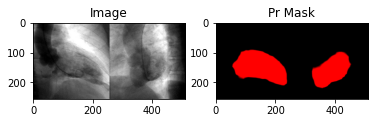

min filename: 0009100091.png


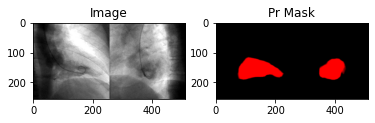

EF((EDV-ESV)/EDV): 67.0
the max area is: [14270, 14486, 14403]
the min area is: [7460, 7271, 7440]
the L of max area is: [188, 192, 192]
the L of min area is: [156, 152, 154]


In [ ]:
combine_2_images()
heart_max, max_file, max_key, heart_min, min_file, min_key, total_images, test_dict = find_max_min(skip_start=s_s, skip_end=s_e, min_threshold=min_t) # skip_start=25, skip_end=25, min_threshold=20
pr_mask_max , pr_mask_min, EF = calculate_EF(max_file, min_file, heart_max, heart_min, total_images, test_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:344: UserWarning: C4326_combined.png is a low contrast image


{-1: 7271, 0: 58265}
{0: 51050, 1: 14486}
{-1: 152, 0: 58017, 1: 7367}


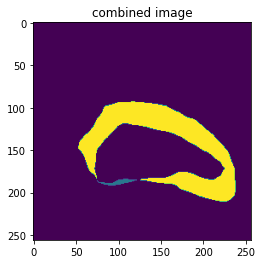

In [ ]:
make_donut(pr_mask_min, pr_mask_max, test_target)

## Lateral view donut

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:400: UserWarning: C3947_combined_l.png is a low contrast image


max_key is: 90
min_key is: 99
max filename: 0009000090.png
min filename: 0009900099.png


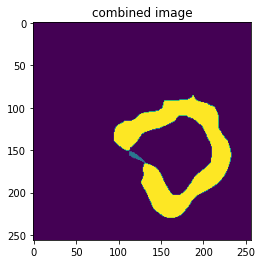

In [ ]:
# use front view max/min keys
# make_lateral_donut(max_file, min_file, test_target)

# search through every lateral view images, comment out if you want to use front view max/min keys
max_file_lateral, min_file_lateral = find_max_min_lateral(test_dict, total_images, skip_start=s_s, skip_end=s_e, min_threshold=min_t) # skip_start=25, skip_end=25, min_threshold=20
make_lateral_donut(max_file_lateral, min_file_lateral, test_target)

## AP Classification

gray area pixel count: 0


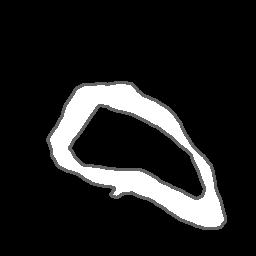

len(contours): 2
contours lenth: 465
contours lenth: 311
predicted output: [[1.1781101e-02 8.4521351e-03 5.9688685e-04 9.7916985e-01]]
the predict result is: Normal


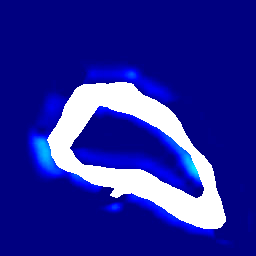

In [ ]:
width, height = 256,256
last_conv_size = 32

path = test_target+"_combined.png"
convert_and_classify_AP(path, width, height, last_conv_size)

## Lateral Classification

gray area pixel count: 25398


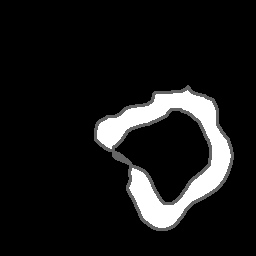

len(contours): 1
contours lenth: 650
predicted output: [[0.98278934 0.00986541 0.0073453 ]]
the predict result is: Normal


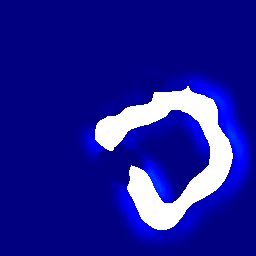

In [ ]:
path = test_target+"_combined_l.png"
convert_and_classify_Lateral(path, width, height, last_conv_size)

https://github.com/qubvel/segmentation_models